#### <b> Convolutional Neural Network for Brain Tumor Detection and Diagnosis (Pytorch, F1-score: 0.97) </b> 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [3]:
metadata_path = '../datasets/brain_tumor_data/metadata.csv'
labels_df = pd.read_csv(metadata_path)
print(labels_df.head().to_markdown())
print("Shape:", labels_df.shape)

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |
Shape: (4600, 6)


In [4]:
import pathlib
import os

data_dir = '../datasets/brain_tumor_data'
data_dir = pathlib.Path(data_dir)
print("Files in dataset directory:", os.listdir(str(data_dir)))

Files in dataset directory: ['.DS_Store', 'healthy', 'brain_tumor', 'metadata.csv', 'metadata_rgb_only.csv']


In [5]:
splitfolders.ratio(str(data_dir), output='brain', seed=20, ratio=(0.8, 0.2))


Copying files: 0 files [00:00, ? files/s]

Copying files: 4600 files [00:02, 2276.12 files/s]


In [6]:
data_dir = pathlib.Path('brain')
print("Split dataset available at:", data_dir)

Split dataset available at: brain


In [7]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)


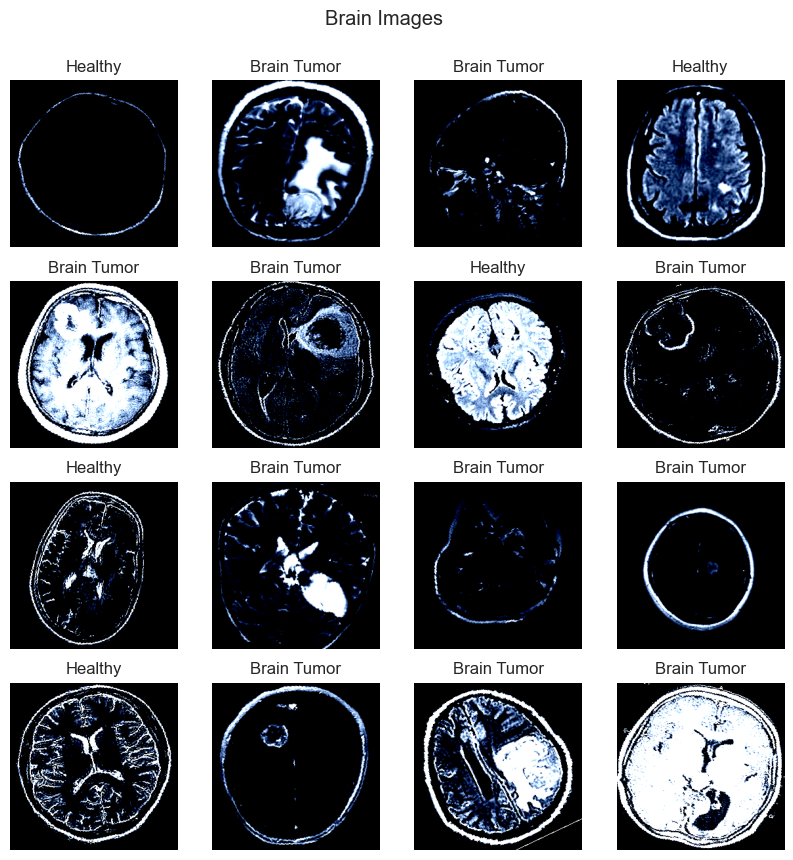

In [10]:
CLA_label = {0: 'Brain Tumor', 1: 'Healthy'} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [11]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break


Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [12]:
def findConv2dOutShape(hin, win, conv, pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    hout = np.floor((hin + 2 * padding[0] - dilation[0]*(kernel_size[0]-1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1]*(kernel_size[1]-1) - 1) / stride[1] + 1)
    if pool:
        hout /= pool
        wout /= pool
    return int(hout), int(wout)

In [13]:
# Define the CNN Architecture For Brain Tumor Model
# ----------------------------
class CNN_TUMOR(nn.Module):  
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()
        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

params_model = {
    "shape_in": (3, 256, 256), 
    "initial_filters": 8,    
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

In [14]:
cnn_model = CNN_TUMOR(params_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)

summary(cnn_model, input_size=(3, 256, 256), device=device.type)

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


In [15]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


In [16]:

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    metric_b = pred.eq(target.view_as(pred)).sum().item()
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [17]:
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    run_loss = 0.0 
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b
        if metric_b is not None:
            t_metric += metric_b    
    loss_val = run_loss / float(len_data)
    metric_val = t_metric / float(len_data)
    return loss_val, metric_val

In [18]:
def Train_Val(model, params, verbose=False):
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    loss_history = {"train": [], "val": []} 
    metric_history = {"train": [], "val": []} 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_loss = float('inf')
    
    for epoch in tqdm(range(epochs)):
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [19]:
params_train = {
    "train": train_loader,
    "val": val_loader,
    "epochs": 60,
    "optimiser": optim.Adam(cnn_model.parameters(), lr=3e-4),
    "lr_change": ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "weights.pt",
}

In [ ]:
cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)

epochs = params_train["epochs"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=list(range(1, epochs+1)), y=loss_hist["train"], ax=ax[0], label='Train Loss')
sns.lineplot(x=list(range(1, epochs+1)), y=loss_hist["val"], ax=ax[0], label='Val Loss')
sns.lineplot(x=list(range(1, epochs+1)), y=metric_hist["train"], ax=ax[1], label='Train Accuracy')
sns.lineplot(x=list(range(1, epochs+1)), y=metric_hist["val"], ax=ax[1], label='Val Accuracy')

def Ture_and_Pred(val_loader, model):
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    return y_true, y_pred

In [ ]:
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    plt.figure(figsize=(10, 7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j]/np.sum(cm)*100:.2f}%", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

In [ ]:
show_confusion_matrix(cm, CLA_label)
torch.save(cnn_model, "../models/Brain_Tumor_model.pt")

---